<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/smc_tempered_1d_bimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustrate SMC with HMC kernel on a 1d bimodal distribution

Code is from
https://github.com/blackjax-devs/blackjax/blob/main/notebooks/TemperedSMC.ipynb


In [1]:
#!pip install blackjax
!pip install git+https://github.com/blackjax-devs/blackjax

  Cloning https://github.com/blackjax-devs/blackjax to /tmp/pip-req-build-juma940_
  Running command git clone -q https://github.com/blackjax-devs/blackjax /tmp/pip-req-build-juma940_
  Created wheel for blackjax: filename=blackjax-0.2.1-py3-none-any.whl size=71257 sha256=3463c47d56d4535a1867d2bd72c1a41028b720c2174af157ee64d56d6b722686
  Stored in directory: /tmp/pip-ephem-wheel-cache-fo5zm9_r/wheels/d3/42/75/b8e1ec1f9f837fdd16abb96cb47725ff083f5f0774610070e4
Successfully built blackjax


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal

jax.config.update("jax_platform_name", "cpu")

from blackjax.hmc import kernel as hmc_kernel
from blackjax.hmc import new_state as hmc_state
from blackjax.inference.smc.resampling import systematic
from blackjax.nuts import kernel as nuts_kernel
from blackjax.nuts import new_state as nuts_state
from blackjax.tempered_smc import TemperedSMCState, adaptive_tempered_smc

# Target distribution

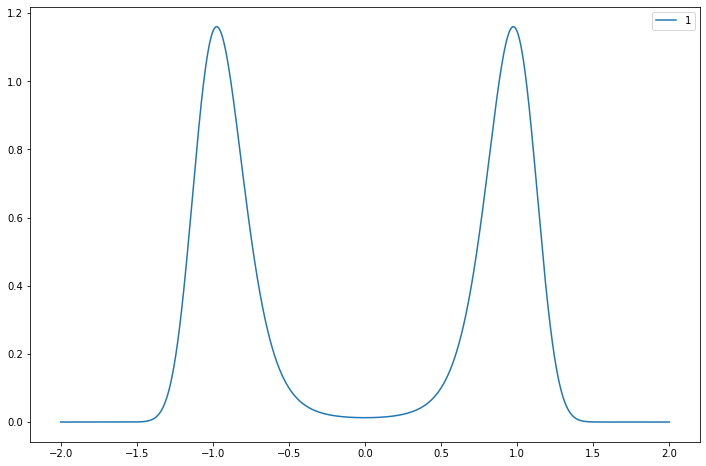

In [3]:
def V(x):
    return 5 * jnp.square(jnp.sum(x**2) - 1)


def prior_log_prob(x):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d))


linspace = jnp.linspace(-2, 2, 5000).reshape(-1, 1)
lambdas = jnp.array([1])
prior_logvals = jnp.vectorize(prior_log_prob, signature="(d)->()")(linspace)
potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)
log_res = prior_logvals.reshape(1, -1) - jnp.expand_dims(lambdas, 1) * potential_vals.reshape(1, -1)

density = jnp.exp(log_res)
normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (linspace[1] - linspace[0])
density /= normalizing_factor

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(linspace.squeeze(), density.T)
ax.legend(list(lambdas))
plt.savefig("bimodal-target.pdf")

# Tempered distribution

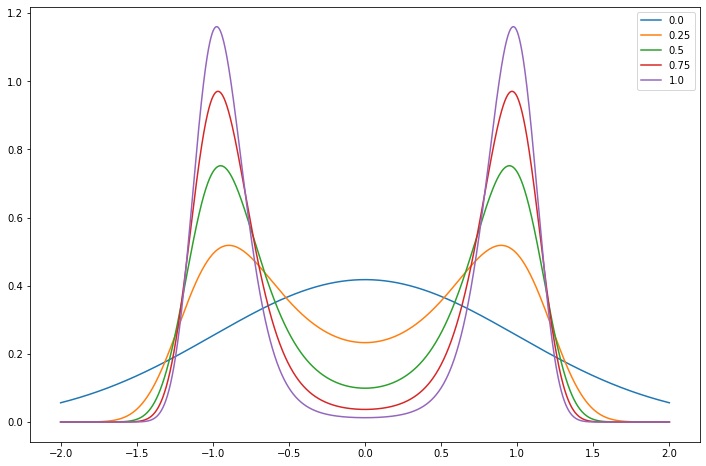

In [4]:
linspace = jnp.linspace(-2, 2, 5000).reshape(-1, 1)
lambdas = jnp.linspace(0.0, 1.0, 5)
prior_logvals = jnp.vectorize(prior_log_prob, signature="(d)->()")(linspace)
potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)
log_res = prior_logvals.reshape(1, -1) - jnp.expand_dims(lambdas, 1) * potential_vals.reshape(1, -1)

density = jnp.exp(log_res)
normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (linspace[1] - linspace[0])
density /= normalizing_factor

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(linspace.squeeze(), density.T)
ax.legend(list(lambdas))
plt.savefig("bimodal-tempered.pdf")

# HMC


In [6]:
def inference_loop(rng_key, mcmc_kernel, initial_state, num_samples):
    def one_step(state, k):
        state, _ = mcmc_kernel(k, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


def full_logprob(x):
    return -V(x) + prior_log_prob(x)


inv_mass_matrix = jnp.eye(1)
n_samples = 10_000

CPU times: user 1.75 s, sys: 57.3 ms, total: 1.81 s
Wall time: 1.77 s


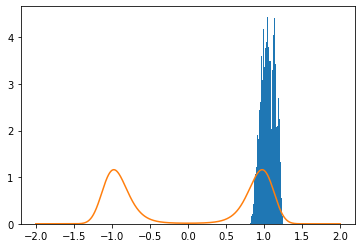

In [7]:
%%time

key = jax.random.PRNGKey(42)

hmc_params = dict(step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=50)

hmc_kernel_instance = jax.jit(hmc_kernel(full_logprob, **hmc_params))
initial_hmc_state = hmc_state(jnp.ones((1,)), full_logprob)
hmc_samples = inference_loop(key, hmc_kernel_instance, initial_hmc_state, n_samples)

_ = plt.hist(hmc_samples.position[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
plt.savefig("bimodal-hmc.pdf")

# NUTS

CPU times: user 8.26 s, sys: 19.5 ms, total: 8.28 s
Wall time: 8.25 s


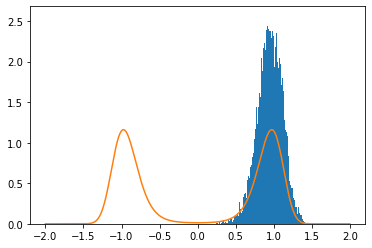

In [8]:
%%time
key = jax.random.PRNGKey(42)
nuts_params = dict(step_size=1e-4, inverse_mass_matrix=inv_mass_matrix)

nuts_kernel_instance = jax.jit(nuts_kernel(full_logprob, **nuts_params))
initial_nuts_state = nuts_state(jnp.ones((1,)), full_logprob)
nuts_samples = inference_loop(key, nuts_kernel_instance, initial_nuts_state, n_samples)

_ = plt.hist(nuts_samples.position[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
plt.savefig("bimodal-nuts.pdf")

# SMC


Number of steps in the adaptive algorithm:  8
CPU times: user 5.37 s, sys: 1.64 s, total: 7.01 s
Wall time: 5.07 s


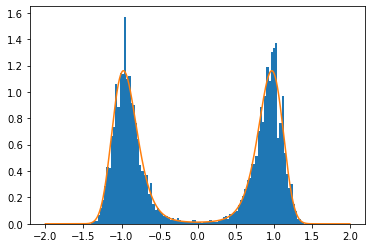

In [9]:
%%time

hmc_factory_params = dict(step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=1)
mcmc_kernel_factory = lambda logprob_fun: hmc_kernel(logprob_fun, **hmc_factory_params)

loglikelihood = lambda x: -V(x)
smc_kernel_instance = jax.jit(
    adaptive_tempered_smc(
        prior_log_prob,
        loglikelihood,
        mcmc_kernel_factory,
        hmc_state,
        systematic,
        0.5,
        mcmc_iter=1,
    )
)
initial_smc_state = jax.random.multivariate_normal(jax.random.PRNGKey(0), jnp.zeros([1]), jnp.eye(1), (n_samples,))
initial_smc_state = TemperedSMCState(initial_smc_state, 0.0)


def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the temepered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, _k = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, k = carry
        k, subk = jax.random.split(k, 2)
        state, _ = smc_kernel(subk, state)
        return i + 1, state, k

    n_iter, final_state, _ = jax.lax.while_loop(cond, one_step, (0, initial_state, rng_key))

    return n_iter, final_state


key = jax.random.PRNGKey(42)
n_iter, smc_samples = smc_inference_loop(key, smc_kernel_instance, initial_smc_state)
print("Number of steps in the adaptive algorithm: ", n_iter.item())
_ = plt.hist(smc_samples.particles[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
plt.savefig("bimodal-smc-tempered.pdf")

# SMC modified

We change the code to track the temperature at each step.
But first we illustrate how to append to a list inside jax while loop. The trick is to use a fixed-size buffer.


In [5]:
def cond_fun(val):
    i, buffer = val
    return i < 5


def body_fun(val):
    i, buffer = val
    i = i + 1
    cur = buffer["current"]
    buffer["data"] = buffer["data"].at[cur].set(i)
    buffer["current"] = cur + 1
    return (i, buffer)


buffer_size = 100
buffer = {"data": jnp.zeros((buffer_size,)), "current": 0}
init_val = (0.0, buffer)
_, buffer = jax.lax.while_loop(cond_fun, body_fun, init_val)
print(buffer)

{'current': DeviceArray(5, dtype=int32, weak_type=True), 'data': DeviceArray([1., 2., 3., 4., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}


If necessary, we can grow the buffer on demand.

In [35]:
def cond_fun(val):
    i, buffer = val
    return (i < 5) & (buffer["current"] < buffer_size)


def body_fun(val):
    i, buffer = val
    i = i + 1
    cur = buffer["current"]
    buffer["data"] = buffer["data"].at[cur].set(i)
    buffer["current"] = cur + 1
    return (i, buffer)


buffer_size = 3
intermediates = []
i = 0.0
while i < 5:
    buffer = {"data": jnp.zeros((buffer_size,)), "current": 0}
    i, buffer = jax.lax.while_loop(cond_fun, body_fun, (i, buffer))
    intermediates += [buffer["data"]]

print(jnp.concatenate(intermediates))

[1. 2. 3. 4. 5. 0.]


Now we return to SMC.


In [27]:
%%time

hmc_factory_params = dict(step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=1)
mcmc_kernel_factory = lambda logprob_fun: hmc_kernel(logprob_fun, **hmc_factory_params)

loglikelihood = lambda x: -V(x)
smc_kernel_instance = jax.jit(
    adaptive_tempered_smc(
        prior_log_prob,
        loglikelihood,
        mcmc_kernel_factory,
        hmc_state,
        systematic,
        0.5,
        mcmc_iter=1,
    )
)
initial_smc_state = jax.random.multivariate_normal(jax.random.PRNGKey(0), jnp.zeros([1]), jnp.eye(1), (n_samples,))
initial_smc_state = TemperedSMCState(initial_smc_state, 0.0)


def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the temepered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, key, buffer = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, key, buffer = carry
        key, subk = jax.random.split(key, 2)
        state, _ = smc_kernel(subk, state)
        # lambdas.append(state.lmbda)
        cur = buffer["current"]
        buffer["data"] = buffer["data"].at[cur].set(state.lmbda)
        # buffer['data'] = buffer['data'].at[cur].set(i)
        buffer["current"] = cur + 1
        return i + 1, state, key, buffer

    # lambdas = []
    # use fixed size array to keep track of lambdas
    buffer_size = 100
    buffer = {"data": jnp.zeros((buffer_size,)), "current": 0}
    n_iter, final_state, key, buffer = jax.lax.while_loop(cond, one_step, (0, initial_state, rng_key, buffer))

    return n_iter, final_state, buffer["data"][:n_iter]


n_iter, smc_samples, lambdas = smc_inference_loop(key, smc_kernel_instance, initial_smc_state)

CPU times: user 4.79 s, sys: 730 ms, total: 5.52 s
Wall time: 4.65 s


In [28]:
print(lambdas)

[0.00538135 0.01532278 0.04021964 0.0823563  0.16662113 0.31522763
 0.60703117 1.        ]


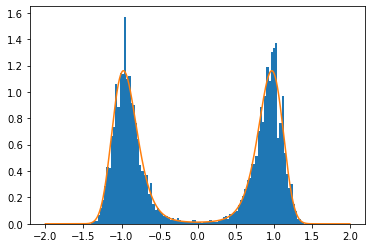

In [32]:
_ = plt.hist(smc_samples.particles[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
plt.savefig("bimodal-smc-tempered.pdf")

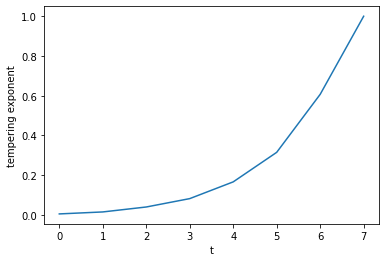

In [33]:
plt.figure()
plt.plot(lambdas)
plt.xlabel("t")
plt.ylabel("tempering exponent")
plt.savefig("bimodal-smc-exponent-vs-time.pdf")

In [ ]:
smc_samples

TemperedSMCState(particles=DeviceArray([[1.146692  ],
             [1.146692  ],
             [1.1463876 ],
             ...,
             [0.57010907],
             [0.70353454],
             [0.7037285 ]], dtype=float32), lmbda=DeviceArray(1., dtype=float32, weak_type=True))

Let's track the adaptive temperature.
 

In [ ]:
smc_samples.particles.shape

(10000, 1)